<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/6_Find_Best_Traffic_Flow_Model_On_NO_SPQ_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

In [3]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [4]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define the path with the data that we are interested in
PATH = '/content/drive/MyDrive/Paper/Timeseries/traffic_flow_without_SPQ.csv'

**Prepare the dataset**

In [6]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [7]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

,Taxi ID,Traj ID,Path,Length,2008-05-17 10:00:04,2008-05-17 10:30:04,2008-05-17 11:00:04,2008-05-17 11:30:04,2008-05-17 12:00:04,2008-05-17 12:30:04,...,2008-06-10 04:30:04,2008-06-10 05:00:04,2008-06-10 05:30:04,2008-06-10 06:00:04,2008-06-10 06:30:04,2008-06-10 07:00:04,2008-06-10 07:30:04,2008-06-10 08:00:04,2008-06-10 08:30:04,2008-06-10 09:00:04
0,304,1291,"[734004334, 734004334, 734004334, 734004334, 7...",17,0,0,11,0,0,0,...,0,0,11,0,0,0,0,0,0,0
1,344,433,"[514685521, 514685521, 306338109, 306338109, 3...",7,101,39,44,27,0,21,...,0,0,0,0,0,9,17,24,0,0


In [8]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [9]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [10]:
# Print dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
67,108,5,0,20,2008-05-17 10:00:04,6
167,108,5,0,20,2008-05-17 10:30:04,6
267,108,5,0,20,2008-05-17 11:00:04,1
367,108,5,0,20,2008-05-17 11:30:04,6
467,108,5,0,20,2008-05-17 12:00:04,0
...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0
114735,168,547,99,2,2008-06-10 07:30:04,0
114835,168,547,99,2,2008-06-10 08:00:04,2
114935,168,547,99,2,2008-06-10 08:30:04,0


**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [11]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [12]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [13]:
# Print traffic_flow dataframe
traffic_flow

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow,hour,dayofweek,day,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
67,108,5,0,20,2008-05-17 10:00:04,6,10,5,17,0,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
167,108,5,0,20,2008-05-17 10:30:04,6,10,5,17,30,5.000000e-01,-0.866025,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
267,108,5,0,20,2008-05-17 11:00:04,1,11,5,17,0,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,4
367,108,5,0,20,2008-05-17 11:30:04,6,11,5,17,30,2.588190e-01,-0.965926,-0.974928,-0.222521,-0.299363,-0.954139,5.665539e-16,-1.0,4
467,108,5,0,20,2008-05-17 12:00:04,0,12,5,17,0,1.224647e-16,-1.000000,-0.974928,-0.222521,-0.299363,-0.954139,0.000000e+00,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114635,168,547,99,2,2008-06-10 07:00:04,0,7,1,10,0,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114735,168,547,99,2,2008-06-10 07:30:04,0,7,1,10,30,9.659258e-01,-0.258819,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3
114835,168,547,99,2,2008-06-10 08:00:04,2,8,1,10,0,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,0.000000e+00,1.0,3
114935,168,547,99,2,2008-06-10 08:30:04,0,8,1,10,30,8.660254e-01,-0.500000,0.781831,0.623490,0.897805,-0.440394,5.665539e-16,-1.0,3


In [14]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


<Axes: >

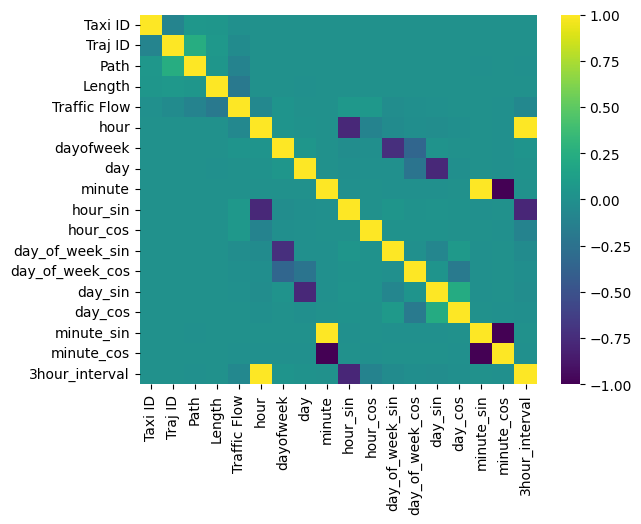

In [18]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [19]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Taxi ID', 'Traj ID', 'Length', 'Traffic Flow', 'hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute', 'minute_cos']

#### **Find the Optimum Sliding Window Length**

In [20]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [21]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [22]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

In [23]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [24]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [25]:
# Define Window Length
optimum_lookback = 2

In [26]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [27]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [28]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [29]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [30]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [31]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.07506	validation_1-rmse:25.68281
[1]	validation_0-rmse:24.60156	validation_1-rmse:24.30703
[2]	validation_0-rmse:23.27273	validation_1-rmse:23.05832
[3]	validation_0-rmse:22.16811	validation_1-rmse:22.03400
[4]	validation_0-rmse:21.12383	validation_1-rmse:21.03991
[5]	validation_0-rmse:20.20624	validation_1-rmse:20.16189
[6]	validation_0-rmse:19.48522	validation_1-rmse:19.48523
[7]	validation_0-rmse:18.86357	validation_1-rmse:18.89544
[8]	validation_0-rmse:18.43637	validation_1-rmse:18.51123
[9]	validation_0-rmse:17.98223	validation_1-rmse:18.07152
[10]	validation_0-rmse:17.50504	validation_1-rmse:17.59075
[11]	validation_0-rmse:17.24142	validation_1-rmse:17.35100
[12]	validation_0-rmse:16.89942	validation_1-rmse:17.00812
[13]	validation_0-rmse:16.57214	validation_1-rmse:16.67229
[14]	validation_0-rmse:16.33354	validation_1-rmse:16.44151
[15]	validation_0-rmse:16.19587	validation_1-rmse:16.31403
[16]	validation_0-rmse:16.07428	validation_1-rmse:16.20139
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [32]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [33]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [34]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.259957008489399
RMSE score: 11.038237932989944


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [35]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [36]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [37]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [38]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [39]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [40]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 12s 40ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 2/50
100/100 [==============================] - 5s 46ms/step - loss: 0.0015 - val_loss: 8.6895e-04
Epoch 3/50
100/100 [==============================] - 2s 16ms/step - loss: 8.2354e-04 - val_loss: 9.2845e-04
Epoch 4/50
100/100 [==============================] - 5s 46ms/step - loss: 7.5600e-04 - val_loss: 8.6037e-04
Epoch 5/50
100/100 [==============================] - 2s 25ms/step - loss: 7.1799e-04 - val_loss: 8.2496e-04
Epoch 6/50
100/100 [==============================] - 5s 55ms/step - loss: 7.0639e-04 - val_loss: 8.2568e-04
Epoch 7/50
100/100 [==============================] - 3s 35ms/step - loss: 6.7187e-04 - val_loss: 8.2496e-04
Epoch 8/50
100/100 [==============================] - 2s 20ms/step - loss: 6.5879e-04 - val_loss: 8.3962e-04
Epoch 9/50
100/100 [==============================] - 4s 38ms/step - loss: 6.3625e-04 - val_loss: 8.1372e-04
Epoch 10/50
100/100 [=========

In [41]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

354/354 [==============================] - 5s 15ms/step - loss: 7.8493e-04
Test Loss: 0.0007849300745874643


In [42]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

354/354 [==============================] - 5s 14ms/step


Evaluate the LSTM model

In [43]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.805539581649072
RMSE LSTM score: 11.514824240049641


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [44]:
# Create dataframe with scores (length == 2)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [45]:
scores # length is 2

,Model,RMSE Score,MAE Score
0,XGBoost,11.038238,5.259957
1,LSTM,11.514824,5.805540


##### Sliding Window Length Equals to 3

In [47]:
# Define Window Length
optimum_lookback = 3

In [48]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [49]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [50]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [51]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [52]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.03006	validation_1-rmse:25.57606
[1]	validation_0-rmse:24.62546	validation_1-rmse:24.27997
[2]	validation_0-rmse:23.40686	validation_1-rmse:23.15752
[3]	validation_0-rmse:22.31970	validation_1-rmse:22.15317
[4]	validation_0-rmse:21.38418	validation_1-rmse:21.27648
[5]	validation_0-rmse:20.44548	validation_1-rmse:20.37058
[6]	validation_0-rmse:19.64636	validation_1-rmse:19.59815
[7]	validation_0-rmse:18.96832	validation_1-rmse:18.94608
[8]	validation_0-rmse:18.33401	validation_1-rmse:18.32372
[9]	validation_0-rmse:17.86529	validation_1-rmse:17.88165
[10]	validation_0-rmse:17.42298	validation_1-rmse:17.45558
[11]	validation_0-rmse:17.14045	validation_1-rmse:17.19613
[12]	validation_0-rmse:16.83546	validation_1-rmse:16.91755
[13]	validation_0-rmse:16.64500	validation_1-rmse:16.75139
[14]	validation_0-rmse:16.33770	validation_1-rmse:16.43044
[15]	validation_0-rmse:16.19007	validation_1-rmse:16.29803
[16]	validation_0-rmse:15.99745	validation_1-rmse:16.11121
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [53]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.23368	validation_1-rmse:24.88500
[1]	validation_0-rmse:23.24737	validation_1-rmse:22.95543
[2]	validation_0-rmse:21.50216	validation_1-rmse:21.19930
[3]	validation_0-rmse:19.96547	validation_1-rmse:19.72037
[4]	validation_0-rmse:18.62538	validation_1-rmse:18.42122
[5]	validation_0-rmse:17.45194	validation_1-rmse:17.25784
[6]	validation_0-rmse:16.43755	validation_1-rmse:16.29861
[7]	validation_0-rmse:15.56045	validation_1-rmse:15.45353
[8]	validation_0-rmse:14.80650	validation_1-rmse:14.70953
[9]	validation_0-rmse:14.15559	validation_1-rmse:14.10329
[10]	validation_0-rmse:13.59341	validation_1-rmse:13.56208
[11]	validation_0-rmse:13.11771	validation_1-rmse:13.13090
[12]	validation_0-rmse:12.71376	validation_1-rmse:12.74323
[13]	validation_0-rmse:12.35714	validation_1-rmse:12.42121
[14]	validation_0-rmse:12.06370	validation_1-rmse:12.14987
[15]	validation_0-rmse:11.80616	validation_1-rmse:11.91661
[16]	validation_0-rmse:11.59813	validation_1-rmse:11.71995
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [54]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [55]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.030151806008071
RMSE score: 10.643128041621766


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [56]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [57]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [58]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [59]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [60]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [61]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 8s 34ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 9.3559e-04
Epoch 3/50
100/100 [==============================] - 7s 67ms/step - loss: 9.1119e-04 - val_loss: 8.4490e-04
Epoch 4/50
100/100 [==============================] - 6s 62ms/step - loss: 7.7236e-04 - val_loss: 8.3305e-04
Epoch 5/50
100/100 [==============================] - 6s 62ms/step - loss: 7.3579e-04 - val_loss: 8.2107e-04
Epoch 6/50
100/100 [==============================] - 6s 62ms/step - loss: 7.1373e-04 - val_loss: 7.7007e-04
Epoch 7/50
100/100 [==============================] - 6s 61ms/step - loss: 6.6598e-04 - val_loss: 8.2569e-04
Epoch 8/50
100/100 [==============================] - 6s 62ms/step - loss: 6.5416e-04 - val_loss: 8.4464e-04
Epoch 9/50
100/100 [==============================] - 6s 62ms/step - loss: 6.4420e-04 - val_loss: 7.8108e-04
Epoch 10/50
100/100 [===========

In [62]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

350/350 [==============================] - 2s 6ms/step - loss: 7.7007e-04
Test Loss: 0.000770067039411515


In [63]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

350/350 [==============================] - 6s 15ms/step


Evaluate the LSTM model

In [64]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.896509654500655
RMSE LSTM score: 11.405282409378456


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [65]:
# Create dataframe with scores (length == 3)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [66]:
scores # length is 3

,Model,RMSE Score,MAE Score
0,XGBoost,10.643128,5.030152
1,LSTM,11.405282,5.896510


##### Sliding Window Length Equals to 4

In [67]:
optimum_lookback = 4

In [68]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [69]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [70]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [71]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [72]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.04295	validation_1-rmse:25.56234
[1]	validation_0-rmse:24.64541	validation_1-rmse:24.28451
[2]	validation_0-rmse:23.43291	validation_1-rmse:23.17588
[3]	validation_0-rmse:22.35601	validation_1-rmse:22.17996
[4]	validation_0-rmse:21.40520	validation_1-rmse:21.29535
[5]	validation_0-rmse:20.48971	validation_1-rmse:20.41538
[6]	validation_0-rmse:19.67242	validation_1-rmse:19.62418
[7]	validation_0-rmse:18.95297	validation_1-rmse:18.92219
[8]	validation_0-rmse:18.41671	validation_1-rmse:18.41695
[9]	validation_0-rmse:17.89458	validation_1-rmse:17.91323
[10]	validation_0-rmse:17.55915	validation_1-rmse:17.60909
[11]	validation_0-rmse:17.18346	validation_1-rmse:17.24490
[12]	validation_0-rmse:16.78842	validation_1-rmse:16.84840
[13]	validation_0-rmse:16.52590	validation_1-rmse:16.59518
[14]	validation_0-rmse:16.35449	validation_1-rmse:16.44316
[15]	validation_0-rmse:16.20916	validation_1-rmse:16.31328
[16]	validation_0-rmse:16.00369	validation_1-rmse:16.11033
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [73]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.24933	validation_1-rmse:24.99505
[1]	validation_0-rmse:23.26866	validation_1-rmse:23.07588
[2]	validation_0-rmse:21.52414	validation_1-rmse:21.39844
[3]	validation_0-rmse:19.98957	validation_1-rmse:19.90258
[4]	validation_0-rmse:18.65251	validation_1-rmse:18.59351
[5]	validation_0-rmse:17.48022	validation_1-rmse:17.48016
[6]	validation_0-rmse:16.46487	validation_1-rmse:16.46552
[7]	validation_0-rmse:15.58401	validation_1-rmse:15.60790
[8]	validation_0-rmse:14.81567	validation_1-rmse:14.89206
[9]	validation_0-rmse:14.16541	validation_1-rmse:14.25852
[10]	validation_0-rmse:13.60070	validation_1-rmse:13.73840
[11]	validation_0-rmse:13.11236	validation_1-rmse:13.27761
[12]	validation_0-rmse:12.69351	validation_1-rmse:12.89736
[13]	validation_0-rmse:12.34804	validation_1-rmse:12.55475
[14]	validation_0-rmse:12.04506	validation_1-rmse:12.27390
[15]	validation_0-rmse:11.78085	validation_1-rmse:12.04284
[16]	validation_0-rmse:11.56107	validation_1-rmse:11.83159
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [74]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [75]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.004721782814275
RMSE score: 10.734238609137762


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [76]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [77]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [78]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [79]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [80]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [81]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 9s 36ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 2/50
100/100 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 8.7713e-04
Epoch 3/50
100/100 [==============================] - 6s 62ms/step - loss: 8.2087e-04 - val_loss: 7.9274e-04
Epoch 4/50
100/100 [==============================] - 6s 62ms/step - loss: 7.4696e-04 - val_loss: 7.6592e-04
Epoch 5/50
100/100 [==============================] - 6s 62ms/step - loss: 6.8554e-04 - val_loss: 7.5311e-04
Epoch 6/50
100/100 [==============================] - 6s 62ms/step - loss: 6.6344e-04 - val_loss: 8.1750e-04
Epoch 7/50
100/100 [==============================] - 6s 62ms/step - loss: 6.3449e-04 - val_loss: 7.3400e-04
Epoch 8/50
100/100 [==============================] - 7s 72ms/step - loss: 6.5195e-04 - val_loss: 7.7573e-04
Epoch 9/50
100/100 [==============================] - 7s 71ms/step - loss: 6.2132e-04 - val_loss: 7.2799e-04
Epoch 10/50
100/100 [==========

In [82]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

347/347 [==============================] - 6s 17ms/step - loss: 7.2799e-04
Test Loss: 0.0007279882556758821


In [83]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

347/347 [==============================] - 11s 30ms/step


Evaluate the LSTM model

In [84]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.596018078241262
RMSE LSTM score: 11.089296475821062


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [85]:
# Create dataframe with scores (length == 4)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [86]:
scores # length is 4

,Model,RMSE Score,MAE Score
0,XGBoost,10.734239,5.004722
1,LSTM,11.089296,5.596018


##### Sliding Window Length equals to 5

In [87]:
optimum_lookback = 5

In [88]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [89]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [90]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [91]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [92]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.05341	validation_1-rmse:25.50523
[1]	validation_0-rmse:24.65532	validation_1-rmse:24.23365
[2]	validation_0-rmse:23.44283	validation_1-rmse:23.13335
[3]	validation_0-rmse:22.36568	validation_1-rmse:22.15043
[4]	validation_0-rmse:21.41489	validation_1-rmse:21.26976
[5]	validation_0-rmse:20.60045	validation_1-rmse:20.51690
[6]	validation_0-rmse:19.77138	validation_1-rmse:19.71518
[7]	validation_0-rmse:19.06961	validation_1-rmse:19.03476
[8]	validation_0-rmse:18.63200	validation_1-rmse:18.64593
[9]	validation_0-rmse:18.16228	validation_1-rmse:18.20066
[10]	validation_0-rmse:17.69789	validation_1-rmse:17.74781
[11]	validation_0-rmse:17.31650	validation_1-rmse:17.38179
[12]	validation_0-rmse:16.96316	validation_1-rmse:17.03375
[13]	validation_0-rmse:16.77057	validation_1-rmse:16.85909
[14]	validation_0-rmse:16.53350	validation_1-rmse:16.64338
[15]	validation_0-rmse:16.31131	validation_1-rmse:16.42136
[16]	validation_0-rmse:16.04376	validation_1-rmse:16.14430
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [93]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.40910	validation_1-rmse:25.04048
[1]	validation_0-rmse:23.56449	validation_1-rmse:23.24735
[2]	validation_0-rmse:21.93834	validation_1-rmse:21.63687
[3]	validation_0-rmse:20.50445	validation_1-rmse:20.24156
[4]	validation_0-rmse:19.24417	validation_1-rmse:19.00377
[5]	validation_0-rmse:18.14276	validation_1-rmse:17.90512
[6]	validation_0-rmse:17.18512	validation_1-rmse:16.96616
[7]	validation_0-rmse:16.35192	validation_1-rmse:16.15222
[8]	validation_0-rmse:15.63424	validation_1-rmse:15.44089
[9]	validation_0-rmse:15.01854	validation_1-rmse:14.80539
[10]	validation_0-rmse:14.47764	validation_1-rmse:14.27482
[11]	validation_0-rmse:14.02795	validation_1-rmse:13.82977
[12]	validation_0-rmse:13.63393	validation_1-rmse:13.44238
[13]	validation_0-rmse:13.29231	validation_1-rmse:13.10253
[14]	validation_0-rmse:13.00934	validation_1-rmse:12.82470
[15]	validation_0-rmse:12.76558	validation_1-rmse:12.58377
[16]	validation_0-rmse:12.55610	validation_1-rmse:12.38283
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [94]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [95]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.100541278568181
RMSE score: 10.902366329994353


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [96]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [97]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [98]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [99]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [100]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [101]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 9s 49ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 2/50
100/100 [==============================] - 7s 67ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 2s 17ms/step - loss: 9.3603e-04 - val_loss: 9.0978e-04
Epoch 4/50
100/100 [==============================] - 6s 62ms/step - loss: 7.8281e-04 - val_loss: 8.8699e-04
Epoch 5/50
100/100 [==============================] - 7s 71ms/step - loss: 6.8974e-04 - val_loss: 8.5040e-04
Epoch 6/50
100/100 [==============================] - 8s 81ms/step - loss: 6.3352e-04 - val_loss: 9.2580e-04
Epoch 7/50
100/100 [==============================] - 7s 72ms/step - loss: 6.1067e-04 - val_loss: 8.9413e-04
Epoch 8/50
100/100 [==============================] - 6s 62ms/step - loss: 5.9585e-04 - val_loss: 8.9967e-04
Epoch 9/50
100/100 [==============================] - 7s 72ms/step - loss: 5.7786e-04 - val_loss: 8.8847e-04
Epoch 10/50
100/100 [==============

In [102]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

344/344 [==============================] - 6s 17ms/step - loss: 8.5040e-04
Test Loss: 0.0008503977442160249


In [103]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

344/344 [==============================] - 5s 14ms/step


Evaluate the LSTM model

In [104]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.439338084491816
RMSE LSTM score: 11.985409099566391


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [105]:
# Create dataframe with scores (length == 5)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [106]:
scores # length is 5

,Model,RMSE Score,MAE Score
0,XGBoost,10.902366,5.100541
1,LSTM,11.985409,5.439338


##### Sliding Window Length Equal to 6

In [107]:
optimum_lookback = 6

In [108]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-08']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-08']

In [109]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, optimum_lookback)
test = generate_X_y_pairs(test, optimum_lookback)

In [110]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:2].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

In [111]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [112]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:26.06363	validation_1-rmse:25.29300
[1]	validation_0-rmse:24.66510	validation_1-rmse:24.02574
[2]	validation_0-rmse:23.45251	validation_1-rmse:22.93101
[3]	validation_0-rmse:22.36982	validation_1-rmse:21.93821
[4]	validation_0-rmse:21.42639	validation_1-rmse:21.07447
[5]	validation_0-rmse:20.61023	validation_1-rmse:20.32692
[6]	validation_0-rmse:19.79003	validation_1-rmse:19.53724
[7]	validation_0-rmse:19.08457	validation_1-rmse:18.86025
[8]	validation_0-rmse:18.49010	validation_1-rmse:18.29626
[9]	validation_0-rmse:17.92824	validation_1-rmse:17.74698
[10]	validation_0-rmse:17.49284	validation_1-rmse:17.33227
[11]	validation_0-rmse:17.14366	validation_1-rmse:17.00618
[12]	validation_0-rmse:16.81104	validation_1-rmse:16.68813
[13]	validation_0-rmse:16.50186	validation_1-rmse:16.38301
[14]	validation_0-rmse:16.33006	validation_1-rmse:16.22939
[15]	validation_0-rmse:16.19550	validation_1-rmse:16.11060
[16]	validation_0-rmse:16.00235	validation_1-rmse:15.92561
[17]	va

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [113]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:25.41786	validation_1-rmse:24.83271
[1]	validation_0-rmse:23.57238	validation_1-rmse:23.04351
[2]	validation_0-rmse:21.94585	validation_1-rmse:21.44493
[3]	validation_0-rmse:20.51165	validation_1-rmse:20.05281
[4]	validation_0-rmse:19.25082	validation_1-rmse:18.82100
[5]	validation_0-rmse:18.15021	validation_1-rmse:17.72351
[6]	validation_0-rmse:17.19186	validation_1-rmse:16.78291
[7]	validation_0-rmse:16.35863	validation_1-rmse:15.97021
[8]	validation_0-rmse:15.64099	validation_1-rmse:15.26604
[9]	validation_0-rmse:15.02568	validation_1-rmse:14.63839
[10]	validation_0-rmse:14.48397	validation_1-rmse:14.10884
[11]	validation_0-rmse:14.03376	validation_1-rmse:13.67084
[12]	validation_0-rmse:13.63865	validation_1-rmse:13.29262
[13]	validation_0-rmse:13.29526	validation_1-rmse:12.95030
[14]	validation_0-rmse:13.01253	validation_1-rmse:12.67447
[15]	validation_0-rmse:12.76644	validation_1-rmse:12.43354
[16]	validation_0-rmse:12.55639	validation_1-rmse:12.21892
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Make predictions on the test set

In [114]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

In [115]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  5.012458868720323
RMSE score: 10.713152841590654


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [116]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [117]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [118]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [119]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [120]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [121]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 6s 16ms/step - loss: 0.0028 - val_loss: 0.0042
Epoch 2/50
100/100 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 9.8159e-04
Epoch 3/50
100/100 [==============================] - 2s 24ms/step - loss: 8.7636e-04 - val_loss: 8.7244e-04
Epoch 4/50
100/100 [==============================] - 6s 58ms/step - loss: 7.3752e-04 - val_loss: 8.9223e-04
Epoch 5/50
100/100 [==============================] - 6s 62ms/step - loss: 7.0095e-04 - val_loss: 7.7940e-04
Epoch 6/50
100/100 [==============================] - 6s 62ms/step - loss: 6.6199e-04 - val_loss: 7.8233e-04
Epoch 7/50
100/100 [==============================] - 6s 62ms/step - loss: 6.3740e-04 - val_loss: 7.7314e-04
Epoch 8/50
100/100 [==============================] - 6s 61ms/step - loss: 6.2481e-04 - val_loss: 8.2628e-04
Epoch 9/50
100/100 [==============================] - 6s 62ms/step - loss: 6.0790e-04 - val_loss: 8.3062e-04
Epoch 10/50
100/100 [===========

In [122]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

341/341 [==============================] - 5s 16ms/step - loss: 7.5480e-04
Test Loss: 0.000754803535528481


In [123]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

341/341 [==============================] - 2s 6ms/step


Evaluate the LSTM model

In [124]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  5.1080233838033235
RMSE LSTM score: 11.291684294339246


Add in the same dataframe the RMSE and MAE scores of each model, in order to compare them

In [125]:
# Create dataframe with scores (length == 6)
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# Define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}

# Add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)

In [126]:
scores # length is 6

,Model,RMSE Score,MAE Score
0,XGBoost,10.713153,5.012459
1,LSTM,11.291684,5.108023
